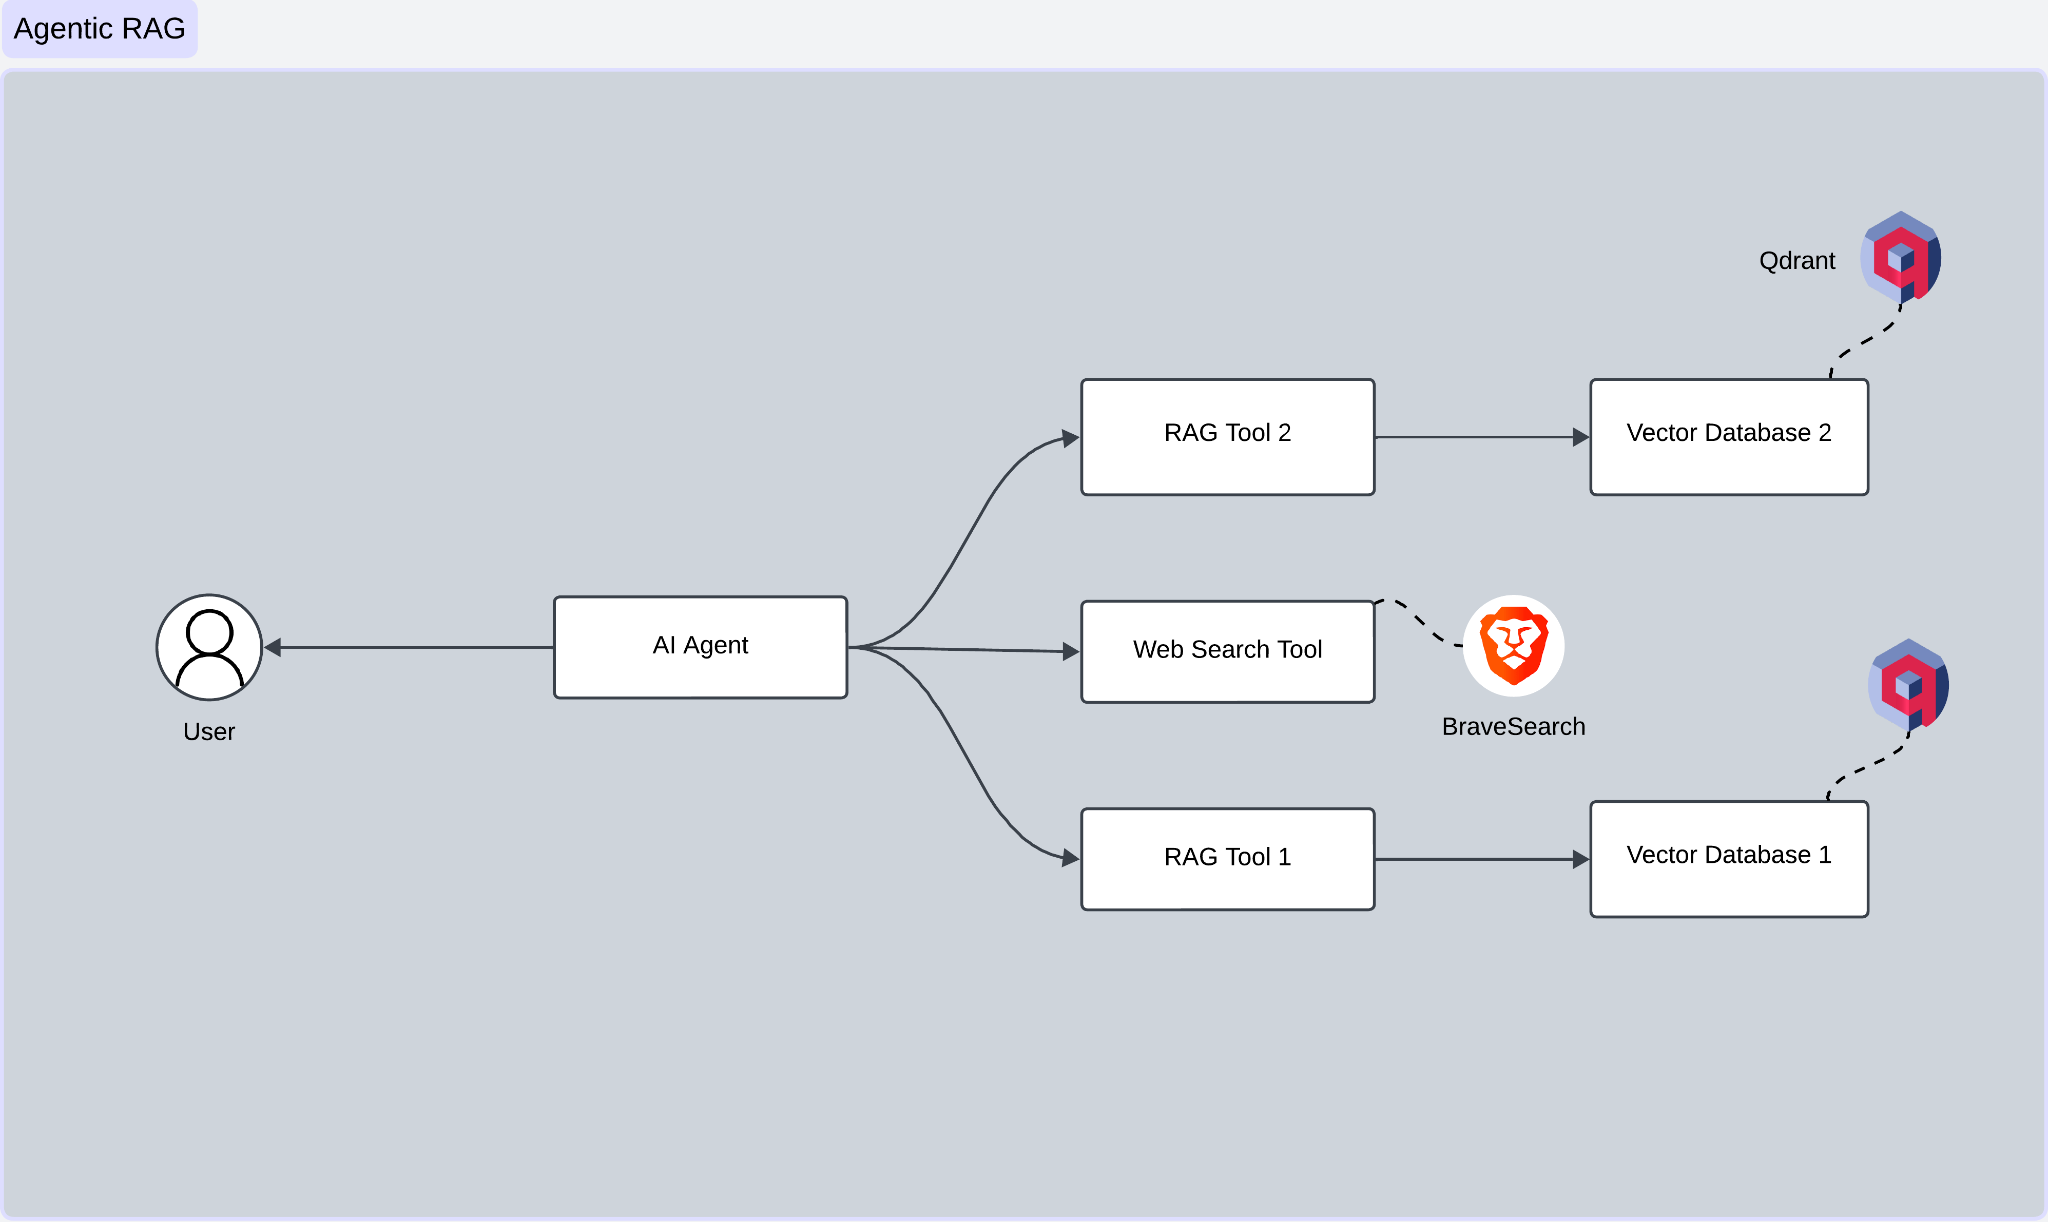

We’re building an AI agent to answer questions about Hugging Face and Transformers documentation using LangGraph. At the heart of our AI agent lies LangGraph, which acts like a conductor in an orchestra. It directs the flow between various components—deciding when to retrieve information, when to perform a web search, and when to generate responses.

The components are: two Qdrant vector stores and the Brave web search engine. However, our agent doesn’t just blindly follow one path. Instead, it evaluates each query and decides whether to tap into the first vector store, the second one, or search the web.

In [ ]:
import os
import json
from typing import Annotated, TypedDict
from dotenv import load_dotenv
# from langchain.embeddings import OpenAIEmbeddings
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langgraph import StateGraph, tool, ToolNode, ToolMessage
from langchain.document_loaders import HuggingFaceDatasetLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
# from langchain.llms import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from qdrant_client import QdrantClient
from qdrant_client.http.models import VectorParams
from brave_search import BraveSearch

In [ ]:
load_dotenv()
qdrant_key = os.getenv("QDRANT_KEY")
qdrant_url = os.getenv("QDRANT_URL")
brave_key = os.getenv("BRAVE_API_KEY")

In [ ]:
# Document Processing and Splitting
def preprocess_dataset(docs_list):
    """Preprocess the dataset by splitting documents into smaller chunks."""
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=700,
        chunk_overlap=50,
        disallowed_special=()
    )
    doc_splits = text_splitter.split_documents(docs_list)
    return doc_splits

In [ ]:
# Load datasets from Hugging Face
hugging_face_doc = HuggingFaceDatasetLoader("m-ric/huggingface_doc","text")
transformers_doc = HuggingFaceDatasetLoader("m-ric/transformers_documentation_en","text")

In [ ]:
# Preprocess datasets
number_of_docs = 50  # Limit the number of documents to process for quicker execution
hf_splits = preprocess_dataset(hugging_face_doc.load()[:number_of_docs])
transformer_splits = preprocess_dataset(transformers_doc.load()[:number_of_docs])

In LangGraph, a state refers to the data or information stored and maintained at a specific point during the execution of a process or a series of operations. States capture the intermediate or final results that the system needs to keep track of to manage and control the flow of tasks, LangGraph works with a state-based system.

In [ ]:
# Defining the State
class State(TypedDict):
    messages: Annotated[list, add_messages]

The agent is equipped with three powerful tools:

1. Hugging Face Documentation Retriever
2. Transformers Documentation Retriever
3. Web Search Tool

In [ ]:
# Retievers Creation Function
# Both the Hugging Face documentation retriever and the Transformers documentation retriever use this same function. 
# With this setup, it’s incredibly simple to create separate tools for each.

def create_retriever(collection_name, doc_splits):
    vectorstore = QdrantVectorStore.from_documents(
        doc_splits,
        # OpenAIEmbeddings(model="text-embedding-3-small"),
        GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001"),
        url=qdrant_url,
        api_key=qdrant_key,
        collection_name=collection_name,
    )
    return vectorstore.as_retriever()

In [ ]:
# # Building the Tools
# hf_retriever_tool = create_retriever_tool(
#     hf_retriever,
#     "retriever_hugging_face_documentation",
#     "Search and return information about hugging face documentation, it includes the guide and Python code.",
# )

# transformer_retriever_tool = create_retriever_tool(
#     transformer_retriever,
#     "retriever_transformer",
#     "Search and return information specifically about transformers library",
# )

In [ ]:
# Building the Tools
hf_retriever_tool = create_retriever(
    hf_retriever, hf_splits)

transformer_retriever_tool = create_retriever(
    transformer_retriever, transformer_splits)

In [ ]:
# # Web search tool using Brave Search API
# @tool
# def web_search(query: str) -> str:
#     """Use Brave Search to search the web for recent information."""
#     brave = BraveSearch(api_key=brave_key)
#     results = brave.search(query, count=3)
#     return json.dumps(results)

In [ ]:
# Web search tool using Brave Search API - from Qdrant documentation
@tool("web_search_tool")
def search_tool(query):
    search = BraveSearch.from_api_key(api_key=brave_key, search_kwargs={"count": 3})
    return search.run(query)

In [ ]:
tools = [hf_retriever_tool, transformer_retriever_tool, search_tool]

tool_node = ToolNode(tools=tools)

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)
# llm = ChatOpenAI(model="gpt-4o", temperature=0)

llm_with_tools = llm.bind_tools(tools)

In [ ]:
def agent(state: State):
    return {"messages" : [llm_with_tools.invoke(state["messages"])]}

In [ ]:
# Routing and Decision Making
# The agent needs to determine when to use tools and when to end the cycle.
def route(state: State):
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"

    return END

# # alternate approach
# from langgraph.prebuilt import tools_condition    

In [ ]:
# Putting It All Together: The Graph
graph_builder = StateGraph(State)

graph_builder.add_node("agent", agent)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "agent",
    route,
    {"tools": "tools", END: END},
)

graph_builder.add_edge(START, "agent")
graph_builder.add_edge("tools", "agent")

graph = graph_builder.compile()

In [ ]:
Image(graph.get_graph().draw_mermaid_png())

In [ ]:
# # Running the Agent
# def run_agent(user_input: str):
#     for event in graph.stream({"messages": [("user", user_input)]}):
#         for value in event.values():
#             print("Assistant:", value["messages"][-1].content)

In [ ]:
# alternate approach
# Routing and Decision Making
# The agent needs to determine when to use tools and when to end the cycle.
from langgraph.prebuilt import tools_condition

# Putting It All Together: The Graph
graph_builder = StateGraph(State)

graph_builder.add_node("agent", agent)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("agent", tools_condition)

graph_builder.add_edge(START, "agent")
graph_builder.add_edge("tools", "agent")

graph = graph_builder.compile()

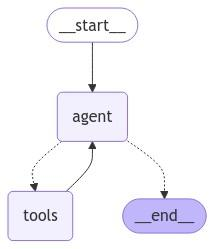

In [ ]:
# Running the Agent
def run_agent(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [ ]:
# example usage
run_agent('In the Transformers library, are there any multilingual models?')